# RNN Model Test ve Değerlendirme
Bu notebook, eğitim aşamasında kaydedilen **RNN (LSTM)** modelini yükleyerek, ayrılmış olan **test verileri** üzerinde performansını ölçer.

Amaç, modelin daha önce hiç görmediği veriler üzerindeki genelleme yeteneğini ve nihai başarımını doğrulamaktır. İşlem adımları:
1. Gerekli kütüphaneler yüklenir.
2. Değerlendirme fonksiyonu tanımlanır.
3. Veri seti (`CREMA-D` veya `EMO-DB`) için kaydedilmiş model ve test verileri (`.pth`, `.npy`, `.pkl`) yüklenir.
4. Modelin test performansı (Accuracy, F1-Score, Precision, Recall, Confusion Matrix) hesaplanır ve görselleştirilir.

## 1. Kütüphanelerin Yüklenmesi ve Ayarlar

In [1]:
#lokalde test edilecekse burası kapatılmalı
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = '/content/drive/MyDrive/AudioEmotionDetection'
os.chdir(project_path)
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/AudioEmotionDetection


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Uyarıları gizle
warnings.filterwarnings('ignore')

# Grafikleri notebook içinde göstermek için
%matplotlib inline

## 2. RNN Modeli Tanımlama

In [3]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=6):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

## 3. Veri Seti Sınıfı

In [4]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

## 4. Model Değerlendirme Fonksiyonu

In [5]:
def evaluate_model(model, test_loader, model_name, dataset_name, le, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Modeli test verisi üzerinde değerlendirir ve sonuçları görselleştirir."""
    model = model.to(device)
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Metrikleri hesapla
    accuracy = accuracy_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds, average='weighted')
    precision = precision_score(test_labels, test_preds, average='weighted')
    recall = recall_score(test_labels, test_preds, average='weighted')
    cm = confusion_matrix(test_labels, test_preds)

    # Sonuçları yazdır
    print(f'--- {model_name} ({dataset_name}) TEST SONUÇLARI ---')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'\nSınıf Bazlı Performans:\n{classification_report(test_labels, test_preds, target_names=le.classes_)}')

    # Karışıklık Matrisini çizdir
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name} ({dataset_name}) Test Karışıklık Matrisi')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()

    return accuracy, f1, precision, recall

## 5. Test Verisi ile Modelin Değerlendirilmesi


==================== CREMA-D TEST AŞAMASI ====================
--- RNN (CREMA-D) TEST SONUÇLARI ---
Accuracy: 0.4841
Precision: 0.4891
Recall: 0.4841
F1-Score: 0.4838

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.64      0.65      0.65       127
     Disgust       0.22      0.26      0.23        74
        Fear       0.47      0.33      0.39       127
       Happy       0.41      0.45      0.43       128
     Neutral       0.52      0.59      0.55       109
         Sad       0.57      0.55      0.56       127

    accuracy                           0.48       692
   macro avg       0.47      0.47      0.47       692
weighted avg       0.49      0.48      0.48       692



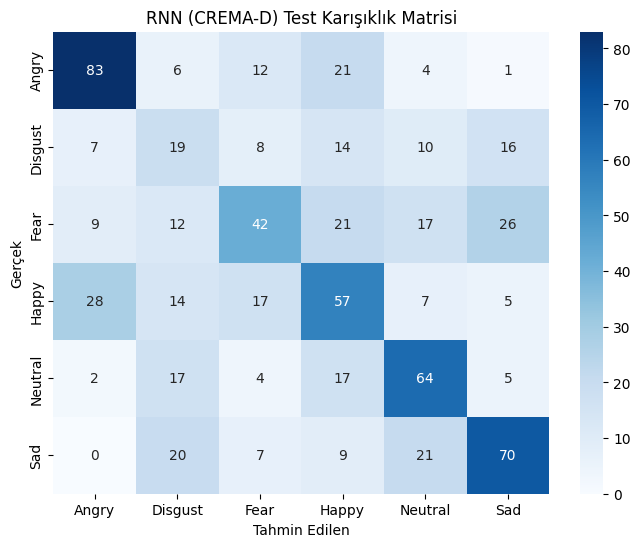


==================== CREMA-D_AUG TEST AŞAMASI ====================
--- RNN (CREMA-D_AUG) TEST SONUÇLARI ---
Accuracy: 0.7798
Precision: 0.7804
Recall: 0.7798
F1-Score: 0.7800

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.87      0.87      0.87       509
     Disgust       0.70      0.75      0.72       296
        Fear       0.73      0.72      0.72       509
       Happy       0.80      0.78      0.79       509
     Neutral       0.82      0.81      0.81       435
         Sad       0.74      0.75      0.75       508

    accuracy                           0.78      2766
   macro avg       0.78      0.78      0.78      2766
weighted avg       0.78      0.78      0.78      2766



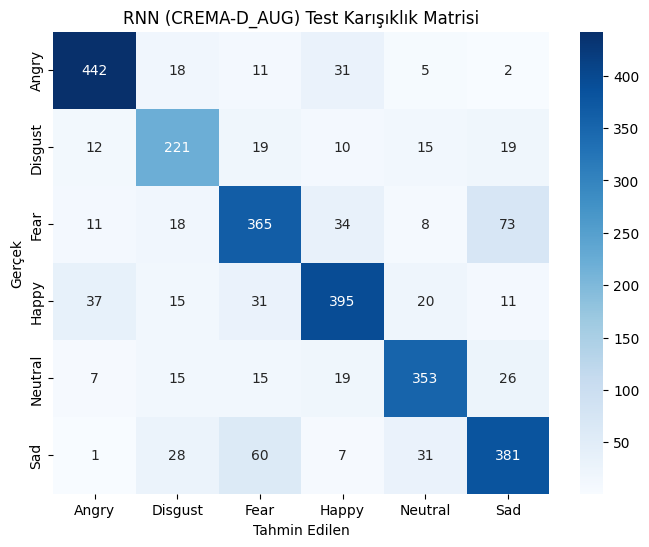


==================== EMO-DB TEST AŞAMASI ====================
--- RNN (EMO-DB) TEST SONUÇLARI ---
Accuracy: 0.4805
Precision: 0.4764
Recall: 0.4805
F1-Score: 0.4757

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.45      0.51      0.47       350
     Disgust       0.50      0.39      0.44       339
        Fear       0.42      0.41      0.41       350
       Happy       0.48      0.53      0.51       350
     Neutral       0.60      0.70      0.65       350
         Sad       0.48      0.50      0.49       350
   Surprised       0.41      0.33      0.36       344

    accuracy                           0.48      2433
   macro avg       0.48      0.48      0.48      2433
weighted avg       0.48      0.48      0.48      2433



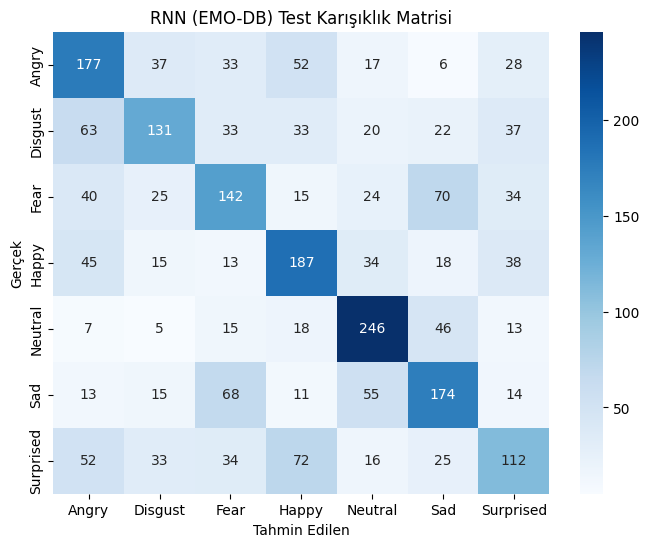

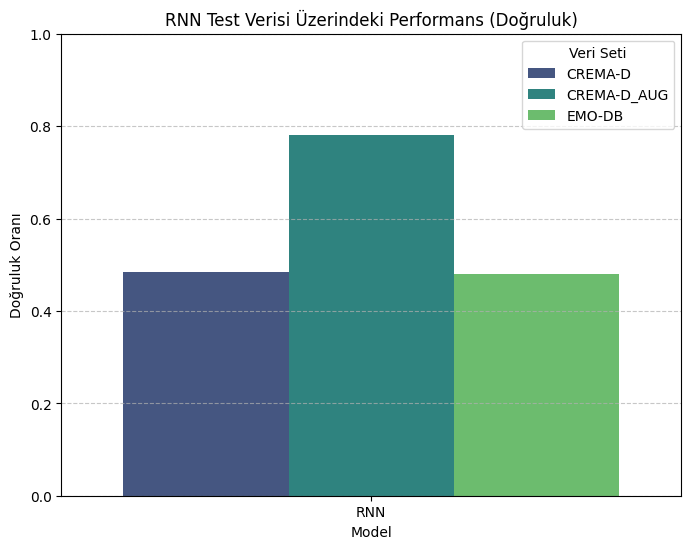

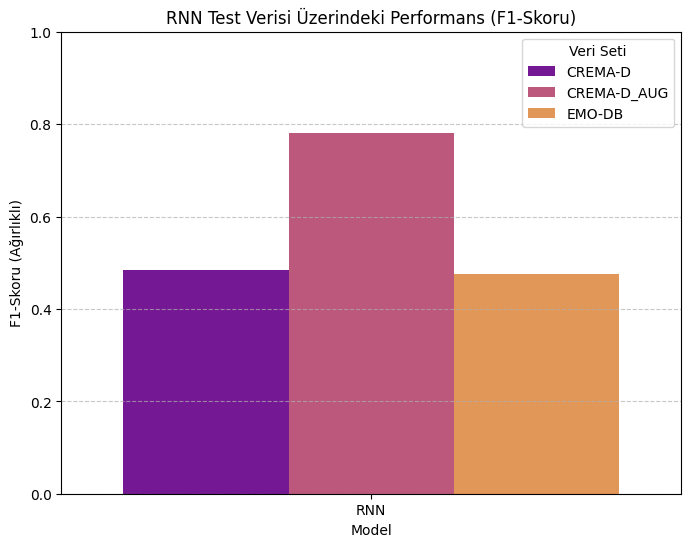

In [6]:
datasets = ['CREMA-D', 'CREMA-D_AUG', 'EMO-DB']  # EMO-DB eklenebilir
test_results = []

for dataset_name in datasets:
    print(f"\n{'='*20} {dataset_name} TEST AŞAMASI {'='*20}")
    try:
        # Kaydedilmiş verileri ve modeli yükle
        X_test = np.load(f'X_test_rnn_{dataset_name}.npy')
        y_test = np.load(f'y_test_rnn_{dataset_name}.npy')
        le = joblib.load(f'label_encoder_{dataset_name}.pkl')

        # RNN modelini başlat
        model = RNNModel(input_size=X_test.shape[2], hidden_size=64, num_layers=2, num_classes=len(le.classes_))
        model.load_state_dict(torch.load(f'rnn_model_{dataset_name}.pth'))

        # Test veri setini hazırla
        test_dataset = AudioDataset(X_test, y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Modeli değerlendir
        rnn_acc, rnn_f1, rnn_pre, rnn_rec = evaluate_model(model, test_loader, 'RNN', dataset_name, le)

        # Sonuçları kaydet
        test_results.append({
            'Model': 'RNN',
            'Accuracy': rnn_acc,
            'F1-Score': rnn_f1,
            'Precision': rnn_pre,
            'Recall': rnn_rec,
            'Dataset': dataset_name
        })
    except FileNotFoundError as e:
        print(f'HATA: {dataset_name} için gerekli dosyalar bulunamadı. Lütfen eğitim notebookunun çalıştığından emin olun.')
        print(f'Eksik dosya: {e.filename}')

# Sonuçları görselleştir
if test_results:
    results_df = pd.DataFrame(test_results)

    # Doğruluk Karşılaştırması
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=results_df, palette='viridis')
    plt.title('RNN Test Verisi Üzerindeki Performans (Doğruluk)')
    plt.ylabel('Doğruluk Oranı')
    plt.xlabel('Model')
    plt.legend(title='Veri Seti')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # F1-Skoru Karşılaştırması
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Model', y='F1-Score', hue='Dataset', data=results_df, palette='plasma')
    plt.title('RNN Test Verisi Üzerindeki Performans (F1-Skoru)')
    plt.ylabel('F1-Skoru (Ağırlıklı)')
    plt.xlabel('Model')
    plt.legend(title='Veri Seti')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Karşılaştırılacak test sonucu bulunamadı. Lütfen eğitim notebookunun çalıştığından emin olun.")